In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

In [3]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [4]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [5]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

print (len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#Table of Classical flares that are between 20-75 minutes as defined in Davenport(2014)

timed_classical = classical_flares[(classical_flares['Flare_Duration'] >= min_dur) & (classical_flares['Flare_Duration'] < max_dur)]
print(len(timed_classical))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641
902
902


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Importing in GJ1243 light curve (DR-25)

In [6]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


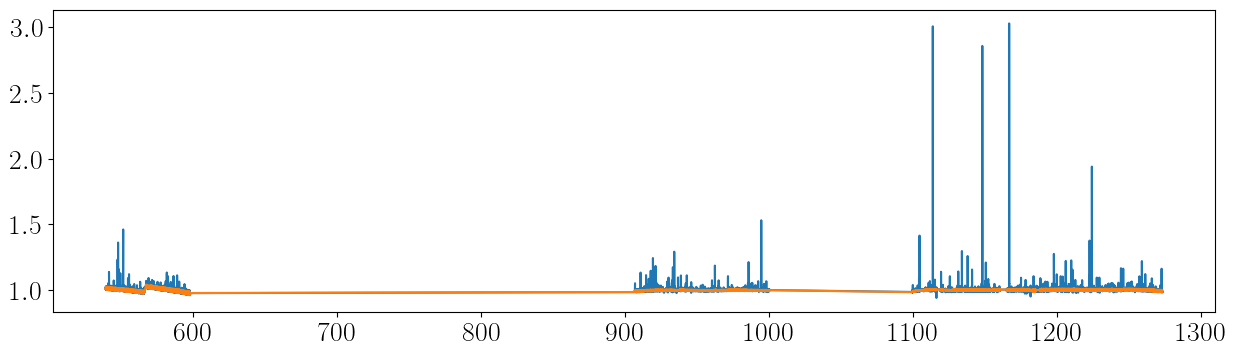

In [7]:
#Reading in the 11 mo gp files
from glob import glob

gp_files = glob('*11mo_*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()


In [8]:
#dropping the nans in the table
df = df.dropna()
df = df.reset_index(drop=True)
print(len(df))

453111


Text(0.5, 0, 'Time - 2457000 [BTJD days]')

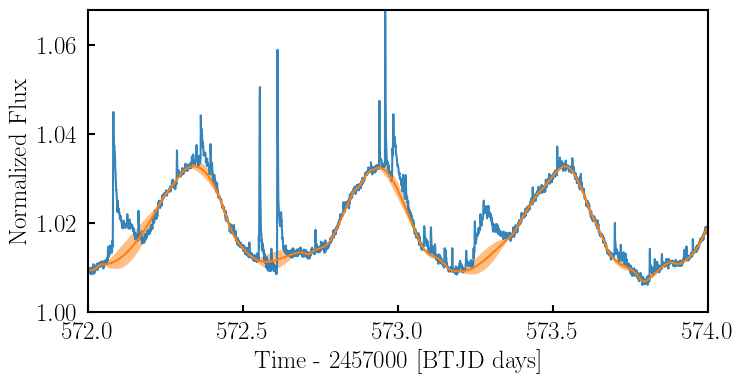

In [9]:

#rcParams["savefig.dpi"] = 300
#rcParams["figure.dpi"] = 100
rcParams["font.size"] = 18
#rcParams["figure.figsize"] = [8, 4]
#rcParams["font.family"] = "sans-serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
#rcParams["text.usetex"] = True

plt.figure(figsize=[8,4])

color = "#ff7f0e"

plt.rcParams['axes.linewidth']=1.5
#plt.rcParams['xtick.major.width'] = 1.5
#plt.rcParams['ytick.major.width'] = 1.5
#plt.rc('xtick.major', size=6, pad=5)
plt.tick_params(direction='in',width=1.5,length=5,pad=7)

plt.xticks(np.arange(572,574.5, step=0.5))


plt.plot(df['time'], df['detrended_flux'],alpha=0.9)
plt.plot(df['time'], df['mean'])
plt.fill_between(df['time'], df['mean']+df['std'], df['mean']-df['std'],color=color, alpha=0.5,
                 edgecolor="none",label='gp')

plt.xlim(572,574)
#plt.xlim(914,916)
plt.ylim(1,1.068)
plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")

#plt.savefig('/Users/lupitatovar/flares/figures/gp_overlay.png',bbox_inches='tight')

#plt.show()

In [10]:
detrended = df['detrended_flux'].values - df['mean'].values
#print(detrended)

In [11]:
#timed_classical
classic_start=timed_classical.loc[:,'t_start'].values
classic_stop=timed_classical.loc[:,'t_stop'].values
classic_dur = timed_classical.loc[:,'Flare_Duration'].values
#print(classic_start)

### Vetted Flares List

In [12]:
new_flares=pd.read_csv('/Users/lupitatovar/flares/notebooks/flare_diagnostics/flare_diagnostics.csv',
            delim_whitespace=True,names=["Flare_Number","Type","Notes"])

In [13]:
flag = pd.to_numeric(new_flares["Type"].values, errors='coerce') #nan = classical , 2= adjust start/stop , 3= remove

In [20]:
# Separating the new set of flares and printing new ammounts of flares

still_classical = len(np.where(np.isnan(flag))[0])
print ("The number of remaining classical flares : " + str(still_classical)) 

toss = len([i for i in flag if i == 3.]) 
print ("The number flares tossed out : " + str(toss)) 

edit = len([i for i in flag if i == 2.]) 
print ("The number of flares who need edited times : " + str(edit)) 


# Creating the data tables of newly classified flares (use these to make stacked flares plot)
edit_times = new_flares[new_flares["Type"].values == '2']
toss_flares = new_flares[new_flares["Type"].values == '3']
still_classic_flares = new_flares[pd.isnull(new_flares["Type"].values)]



#includes flares that need start/stop times edited
keep_flares = edit_times.combine_first(still_classic_flares)

The number of remaining classical flares : 476
The number flares tossed out : 341
The number of flares who need edited times : 83


In [21]:
#adding index column to Jim's original timed_calssical flares list
timed_classical['Index'] = np.arange(len(timed_classical))
#timed_classical

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
#cross matching the two lists to get new table that has all the flare info!

cross_match = pd.merge(left=timed_classical, right=keep_flares, left_on='Index', right_on='Flare_Number')
cross_match.shape
#cross_match


(558, 20)

In [26]:
# These complex flares are from Jim's original sample (new vetted complex flares are not included ... )
print(len(complex_flares))
print(len(timed_classical))

945
902


### Trying out new stacking procedure for complex flares

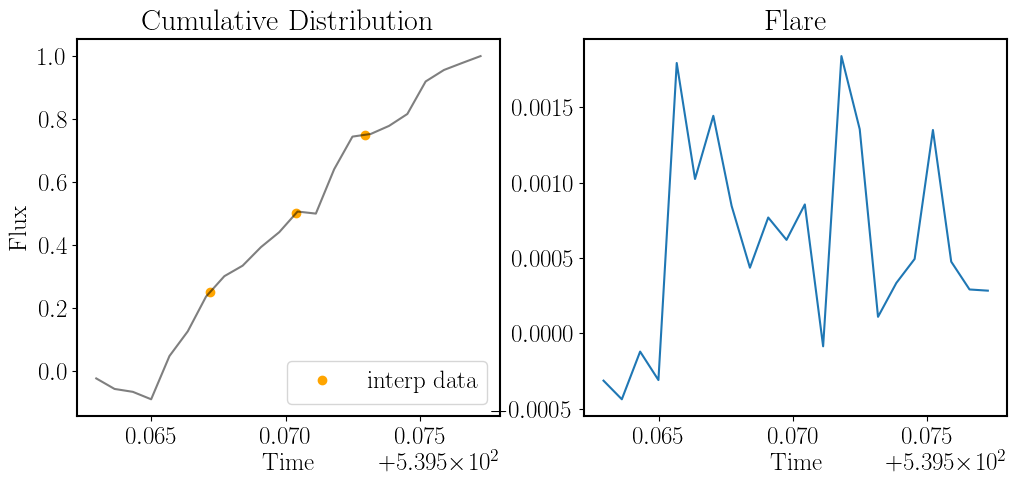

In [27]:
i=0
#Mask of the times (t_start and t_stop) between each flare 
temp = np.where((df['time'] < complex_flares['t_stop'].values[i]) & 
                    (df['time'] > complex_flares['t_start'].values[i]))[0]
    
# cummulative distribution of detrended fluxes within each flare
cd_detrended = np.cumsum((detrended[temp])/np.sum(detrended[temp]))

#print(cd_detrended)
    
#print((cd_detrended[i]),(df['time'][i]))

# interpolation over the flux of each flare: yvals are percentiles of cummulative flux & x_interp gives corresponding times
# note that we are looking at times and fluxes in cummulative space
    
yvals = np.array([0.25,0.5,0.75])
xinterp = np.interp(yvals, cd_detrended, df['time'][temp])

#############. Plotting #################


rcParams["figure.figsize"] = [12, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)


ax1.plot(xinterp,yvals,'o',color='orange', label= 'interp data')

ax1.plot(df['time'][temp],cd_detrended,alpha=0.5,color='k')
ax2.plot(df['time'][temp],detrended[temp])

#start/stop times
#ax1.axvline(x=timed_classical['t_start'].values[i], color='g', linestyle='-')
#ax1.axvline(x=timed_classical['t_stop'].values[i], color='g', linestyle='-')

#ax2.axvline(x=timed_classical['t_start'].values[i], color='g', linestyle='-')
#ax2.axvline(x=timed_classical['t_stop'].values[i], color='g', linestyle='-')

#ax2.scatter(xinterp[2],yvals[2],color='orange')

#Setting Titles

ax1.set_title('Cumulative Distribution')
ax2.set_title('Flare')

#Axes
ax1.set_ylabel("Flux")
ax1.set_xlabel("Time")
ax2.set_xlabel("Time")

#Legend
ax1.legend(loc='lower right')

In [29]:
print(xinterp)
print(yvals)
print(complex_flares['t_start'].values[i])
print(complex_flares['t_stop'].values[i])

[539.56718306 539.57037829 539.57295253]
[0.25 0.5  0.75]
539.5628662
539.5778197999999


#### Translating cumulative distribution back to corresponding interpolated flare to get a flux value


Text(0, 0.5, 'Flux')

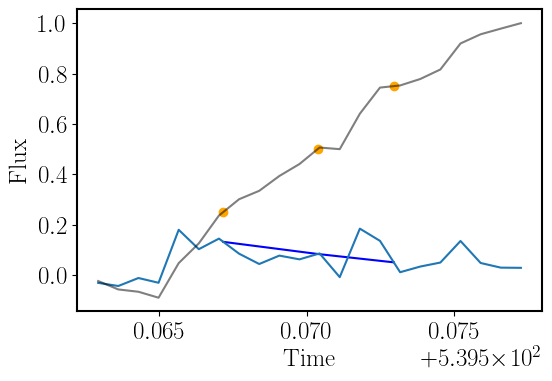

In [30]:
i=0

new_y_interp_vals = np.interp(xinterp,df['time'][temp],detrended[temp])

#############. Plotting #################
plt.figure(figsize=[6,4])
plt.plot(xinterp,new_y_interp_vals *100,color='blue', label = 'flare')

plt.plot(xinterp,yvals,'o',color='orange', label= 'interp data')
plt.plot(df['time'][temp],detrended[temp]*100)
plt.plot(df['time'][temp],cd_detrended,alpha=0.5,color='k')
#plt.plot(df['time'][temp],detrended[temp])


plt.xlabel('Time')
plt.ylabel('Flux')

We can try using different yvals

In [31]:
print(new_y_interp_vals)
print(xinterp)
print(df['time'][temp].values)
print(detrended[temp][0])

[0.0013158  0.00083398 0.00050243]
[539.56718306 539.57037829 539.57295253]
[539.56294991 539.56363114 539.56431226 539.56499338 539.5656746
 539.56635562 539.56703675 539.56771797 539.56839909 539.56908021
 539.56976144 539.57044256 539.57112378 539.5718048  539.57248593
 539.57316705 539.57384827 539.57452939 539.57521061 539.57589174
 539.57657286 539.57725388]
-0.00031303823602990555


## Stacked classical flares with newly vetted flare list

Variables being calculated for the flare model: center time, scale height, scale duration

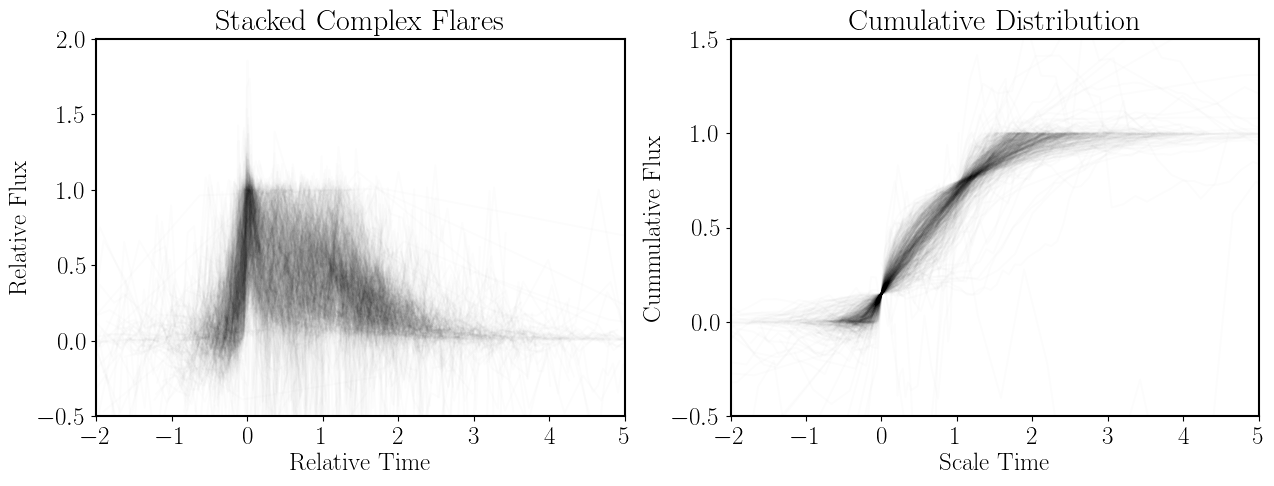

In [40]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

cmplx_t_center = np.array([])          # time at 50% cummulative flux of each flare
cmplx_scale_height = np.array([])  # mean flux of the entire flare 
cmplx_scale_dur = np.array([])     # (t_75 - t_25)


for i in range(0,len(cross_match)):

    #Mask of the times (t_start and t_stop) between each flare 
    temp = np.where((df['time'] < complex_flares['t_stop'].values[i]) & 
                    (df['time'] > complex_flares['t_start'].values[i]))[0]
    
    # cummulative distribution of detrended fluxes within each flare
    cd_detrended = np.cumsum((detrended[temp])/np.sum(detrended[temp]))
    

    # interpolation over the flux of each flare: yvals are percentiles of cummulative flux & x_interp gives corresponding times
    # note that we are looking at times and fluxes in cummulative space
    
    yvals = np.array([0.15,0.25,0.75])
    xinterp = np.interp(yvals, cd_detrended, df['time'][temp])

    # t_50
    #cd_i_max = np.argmax(detrended[temp])
    #t_max = (df['time'].values[temp][cd_i_max])
    #cd_flux_max = (detrended[temp][cd_i_max])
    
    
    #double check this part
    t1 = xinterp[0]
    t2 = xinterp[1]#cd_flux_max / 2.0
    t3 = xinterp[2]
    
    cmplx_t_center = np.append(cmplx_t_center,t1)
    
    #i_xs = np.where((xinterp[temp] > t_50_flux[i]))[0]
    #time_xs = yvals[temp][i_xs]
    
    # defining the scale height
    cd_mean = np.cumsum(detrended[temp])    #explore this a little more (have tried mean, sum, median)
    #scale_height = np.append(scale_height,cd_mean)
    
    
    #testing interpolating over the fluxes instead of using mean flux
    height_interp = np.interp(0.99, np.linspace(0,1,len(detrended[temp])), np.sort(detrended[temp]))
    cmplx_scale_height = np.append(cmplx_scale_height,height_interp)
    
    # scale duration

    diff_dur = np.abs(t3 - t2)
    cmplx_scale_dur = np.append(cmplx_scale_dur,diff_dur)
    
    
    ######## PLOTTING ################

    cmplx_x = (df['time'][temp] - cmplx_t_center[i])/(cmplx_scale_dur[i])
    cmplx_y = ((detrended[temp])/(cmplx_scale_height[i]))

    
    #ax1.plot(xinterp,yvals,'o',color='orange', label= 'interp data')

    axs[0].plot(cmplx_x,cmplx_y,color='k',alpha=0.01)

    #axs[1].plot((xinterp[2]-xinterp)/new_scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    axs[1].plot((df['time'][temp]-cmplx_t_center[i])/cmplx_scale_dur[i],cd_detrended,color='k',alpha=0.01)
    
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Complex Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Scale Time")

    #Axes limits

    axs[0].set_xlim(-2,5)
    axs[0].set_ylim(-0.5,2) 
    
    axs[1].set_xlim(-2,5)
    axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')


In [35]:
print(len(timed_classical))
print(len(cross_match))
print(len(complex_flares))

902
558
945


### Comparison of DR25 and DR23

In [36]:
#time,flux,err,detrended_flux
dr23 = pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/1732d4130daf663532596749d566d8f78be8f7b2/data/gj1243_master_slc.dat'
                  ,skiprows=1,delim_whitespace=True,names=['time','flux','error','detrended_flux'])

#dr23



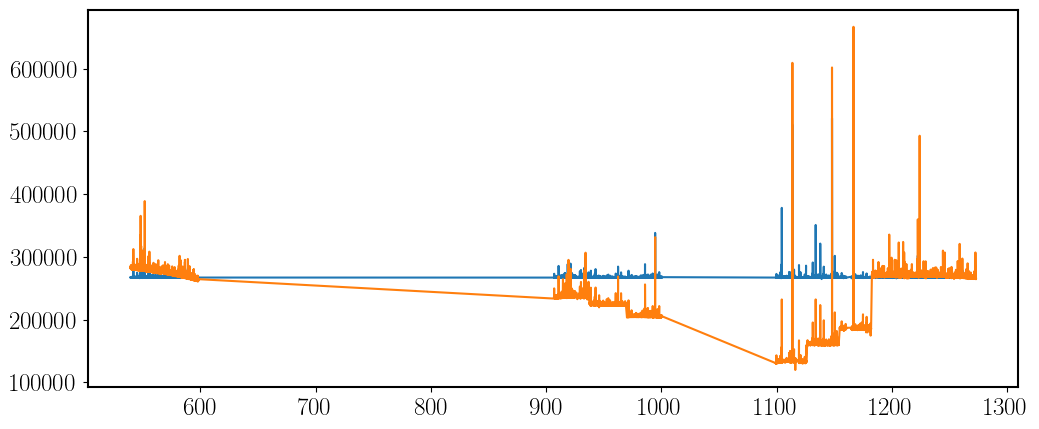

In [37]:
plt.plot(dr23['time'].values,dr23['detrended_flux'].values)
plt.plot(gj1243lc.time,gj1243lc.flux)

### Overplotting Jim's flare model onto this w/ amp=1,t_half=1,peak=0
https://github.com/jradavenport/appaloosa/blob/master/appaloosa/aflare.py

In [108]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

(-5.0, 15.0)

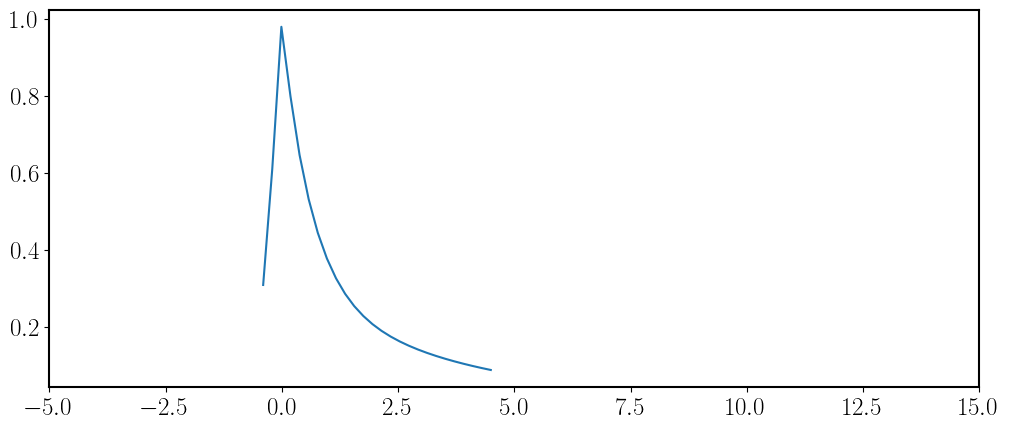

In [110]:
plt.plot(new_x,aflare1(new_x.values,0,1,1))
#plt.plot(x,jim_model,color='red')
plt.xlim(-5,15)

The arrays below contain time, flux, flux_err, and standard deviation for each flare within the ranges of [-5,15]

In [ ]:
new_x_all=np.array([])
new_y_all=np.array([])
new_y_err = np.array([])
new_gp_st_dev = np.array([])
xmin=-5
xmax=15


for i in range(0,len(cross_match)):
        x_new = (df['time'].values - new_time_max[i])/(new_t_halfs[i])
        y_new = ((detrended)/(new_peaks[i]))
        plt.plot(x_new,y_new,color='b',alpha=0.01)

        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.4,1.05)
        plt.xlim(-5,15)
        
        #Time Arrays
        nxs = np.where((x_new <= xmax) & (x_new>=xmin))[0]
        new_x_all = np.append(new_x_all,x_new[nxs])
        
        #Flux Arrays
        new_y_all = np.append(new_y_all,y_new[nxs])
        
        #Flux Errors
        new_flux_err = df['df_flux_err'].values/new_peaks[i] 
        new_y_err = np.append(new_y_err,new_flux_err[nxs])
        
        #GP Standard Deviation
        new_st_dev = df['std'].values/new_peaks[i]
        new_gp_st_dev = np.append(new_gp_st_dev,new_st_dev[nxs])
                  
plt.plot(x_new,aflare1(x_new,0,1,1),color='red',label='Jims Model')        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
#saving the arrays to a file
#dict_i = {'time':x_all,'flux': y_all, 'flux_err': y_err, 'gp_st_dev': gp_st_dev} 
#stacked_flares = pd.DataFrame(data=dict_i) 
#stacked_flares.to_csv(r'stacked_flare_values.csv',header=True,index=True)


#dict_n = {'time':new_x_all,'flux': new_y_all, 'flux_err': new_y_err, 'gp_st_dev': new_gp_st_dev} 
#new_stacked_flares = pd.DataFrame(data=dict_n) 
#new_stacked_flares.to_csv(r'new_stacked_flare_values.csv',header=True,index=True)

In [ ]:
#new_stacked_flare_vals=pd.read_csv('stacked_flare_values.csv')

In [ ]:
s_all = np.argsort(x_all)
jim_model = aflare1(x_all,0,1,1)
plt.scatter(x_all,y_all,alpha=.07,s=10,marker='.')
plt.ylim(-0.4,1.05)
plt.plot(x_all[s_all],jim_model[s_all],color='red')  
plt.xlabel('Time')
plt.ylabel('Relative Flux')

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
ns_all = np.argsort(new_x_all)
jim_model = aflare1(new_x_all,0,1,1)

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True


plt.scatter(new_x_all,new_y_all,alpha=.15,s=10,marker='.',color='grey')
plt.ylim(-0.2,1.05)
plt.xlim(-5,15)
plt.plot(new_x_all[ns_all],jim_model[ns_all],color='firebrick')  
plt.xlabel('Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/flares/figures/new_stacked_2014fit.png',bbox_inches='tight')

In [ ]:
#plot of the gp uncertainty in our detrended data
plt.scatter(new_x_all[ns_all],new_gp_st_dev[ns_all],alpha=.05,s=10,marker='.')
plt.ylim(0,.2)

Below is the flux error from the gp. We expect it to be a straight line centered at zero, however there is some variance between 0-0.3

In [ ]:
#plot the rolling mean and y_err

plt.scatter(new_x_all[ns_all],new_y_err[ns_all],alpha=.05,s=8,marker='.')
#plt.ylim(0,1)

In [ ]:
#plotting the variance of the st_dev (which is just the st_dev squared?)
plt.scatter(new_x_all,new_gp_st_dev**2,alpha=.05,s=10,marker='.')
plt.ylim(0,.2)

### Fitting the Model

Importing in the new continuous model

In [ ]:
'''
Now lets combine the two functions into one continuous analytic flare model

    Parameters (similar as Davenport 2014 aflare1 model)
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    t_0 : float
        The time of the flare peak
    sig/tau : float
        The "Full Width at Half Maximum", timescale of the flare
    A/amp : float
        The amplitude of the flare
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time

'''
